In [1]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Import CSV for nominal elses
elses = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order\lithwick_else.csv")
elses.head()

,System,MMR,P_in,P_out,V_in,V_out,z_free_in,z_free_out,Z_free,m_sol_in,m_sol_in_err,m_sol_out,m_sol_out_err
0,Figure 2-1,2:1,7.642,14.86,na,na,0,0.00,0.00,17.3,1.7,15.8,1.3
1,Figure 2-2,2:1,7.642,14.86,na,na,0.03j,0.00,NaN,17.3,1.7,15.8,1.3
2,Figure 3,2:1,7.642,14.86,na,na,0.05,0.05,NaN,3.46,0.34,5.846,0.481
3,Kepler 25b/c,2:1,6.239,12.72,0.0026,0.00072,NaN,NaN,-0.05,0.59,0,3.0,0
4,Kepler 23b/c,3:2,7.107,10.74,0.031,0.013,NaN,NaN,0.03,na,na,na,na


In [2]:
# Focus only on figure 2-1, 2-2, and 2-3 recreation
figs = elses[['System', 'MMR', 'P_in', 'P_out', 'z_free_in', 'z_free_out',
              'm_sol_in', 'm_sol_in_err', 'm_sol_out', 'm_sol_out_err']][:3]
figs.head()

,System,MMR,P_in,P_out,z_free_in,z_free_out,m_sol_in,m_sol_in_err,m_sol_out,m_sol_out_err
0,Figure 2-1,2:1,7.642,14.86,0,0.00,17.3,1.7,15.8,1.3
1,Figure 2-2,2:1,7.642,14.86,0.03j,0.00,17.3,1.7,15.8,1.3
2,Figure 3,2:1,7.642,14.86,0.05,0.05,3.46,0.34,5.846,0.481


e1, w1, m1 | e2, w2, m2 | R2_1, R2_2
0.0 0.0 17.3 0.0 0.0 15.8 0.9958037033899645 0.9935311047067762


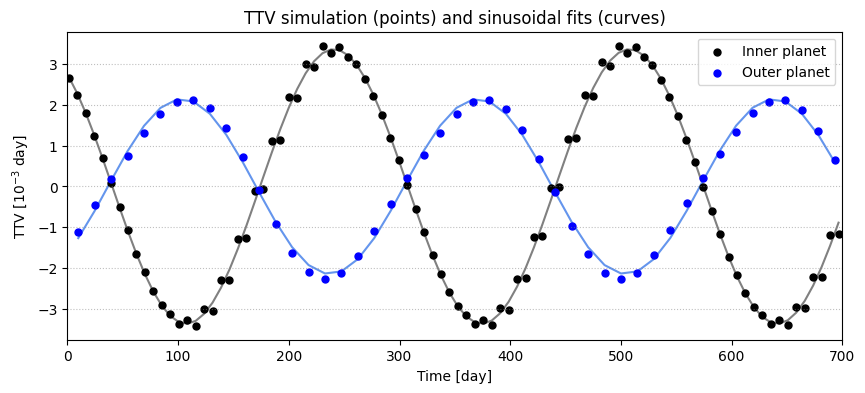

e1, w1, m1 | e2, w2, m2 | R2_1, R2_2
0.03 90.0 17.3 0.0 0.0 15.8 0.998021585241641 0.9970182843418927


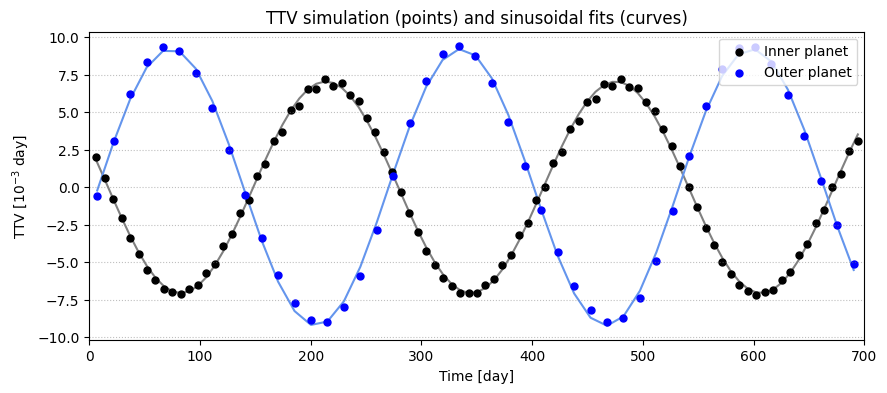

e1, w1, m1 | e2, w2, m2 | R2_1, R2_2
0.05 0.0 3.46 0.05 0.0 5.846 0.9840970408333999 0.998596225580848


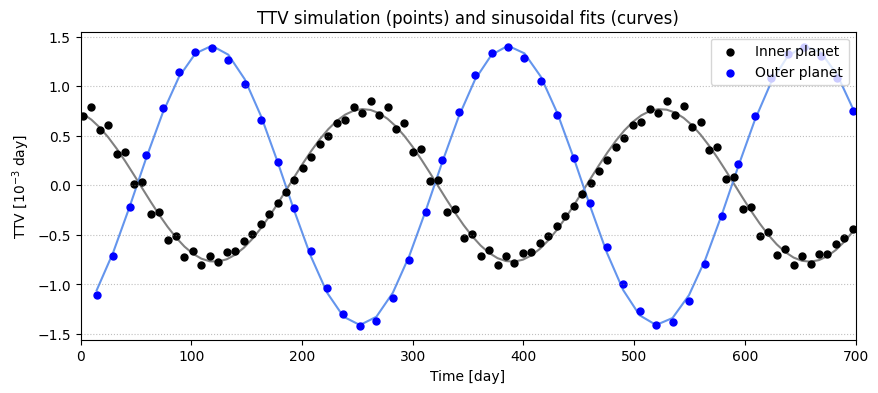

,System,MMR,P_in,P_out,z_free_in,z_free_out,m_sol_in,m_sol_in_err,m_sol_out,m_sol_out_err,V_in,V_out,PTTV_in,PTTV_out
0,Figure 2-1,2:1,7.642,14.86,0,0.00,17.3,1.7,15.8,1.3,0.003361,0.002144,266.931965,267.339589
1,Figure 2-2,2:1,7.642,14.86,0.03j,0.00,17.3,1.7,15.8,1.3,0.007051,0.009227,262.130549,262.234646
2,Figure 3,2:1,7.642,14.86,0.05,0.05,3.46,0.34,5.846,0.481,0.00077,0.00141,268.482996,268.669713


In [4]:
figs_simmed = figs.copy() # figs with simulated outputs
newcols = ['V_in', 'V_out', 'PTTV_in', 'PTTV_out']
figs_simmed[newcols] = None    # new empty columns to add

# Create TTV simulations and extract Amplitude and Period
for i, row in figs_simmed.iterrows():
    # Initialize variables
    gravity = 0.000295994511 # AU^3/day^2/M_sun
    stellar_mass = 0.972     # M_sun

    P_in = row['P_in']
    P_out = row['P_out']
    PTTV = 1/np.abs(2/P_out - (2-1)/P_in)

    e1 = np.abs(complex(row['z_free_in']))
    w1 = np.angle(complex(row['z_free_in']), deg=True)
    e2 = np.abs(complex(row['z_free_out']))
    w2 = np.angle(complex(row['z_free_out']), deg=True)
    
    m1 = float(row['m_sol_in'])
    m2 = float(row['m_sol_out'])
    
    # Create TTVFast planets
    planet1 = models.Planet(
        mass=(m1 * M_earth).to(u.M_sun).value,    # M_sun
        period=P_in,         # days
        eccentricity=e1,
        inclination=90,      # degrees
        longnode=0,          # degrees
        argument=90+w1,      # degrees
        mean_anomaly=0       # degrees
    )
    planet2 = models.Planet(
        mass=(m2 * M_earth).to(u.M_sun).value,
        period=P_out,
        eccentricity=e2,
        inclination=90,
        longnode=0,
        argument=90+w2,
        mean_anomaly=0,
    )
    planets = [planet1, planet2]
    
    begin_time = -P_out * 1200
    Time = begin_time     # days
    dt = P_in / 30        # days
    Total = 700  # days
    
    results = ttvfast.ttvfast(planets, stellar_mass, Time, dt, Total,
                             input_flag=1)

    # Create TTV signal from TTVFast Output
    df = pd.DataFrame(results['positions']).transpose()
    df.columns = ['planet', 'epoch', 'times', 'rsky', 'vsky']
    
    table0 = df[(df.planet == 0) & (df.times > 0)]
    n0 = table0.epoch
    tn0 = table0.times
    time0, ttv0, ttv0_err = ttvfit.return_ttv(epochs=n0, midtransits=tn0)
    
    table1 = df[(df.planet == 1) & (df.times > 0)]
    n1 = table1.epoch
    tn1 = table1.times
    time1, ttv1, ttv1_err = ttvfit.return_ttv(epochs=n1, midtransits=tn1)
    
    # Make sure ttv0 and ttv1 actually are centered around O-C = 0
    ttv0 = ttv0 - (np.max(ttv0) + np.min(ttv0)) / 2
    ttv1 = ttv1 - (np.max(ttv1) + np.min(ttv1)) / 2
    
    # Get sinusoidal TTV model parameters
    popt_ttv0, perr_ttv0, r2_0 = ttvfit.characterize_ttv(time=time0, ttv=ttv0, ttv_err=ttv0_err,
                                                       expected_period=PTTV, method='lmfit')
    popt_ttv1, perr_ttv1, r2_1 = ttvfit.characterize_ttv(time=time1, ttv=ttv1, ttv_err=ttv1_err,
                                                       expected_period=PTTV, method='lmfit')

    figs_simmed.loc[i, newcols] = [popt_ttv0[2], popt_ttv1[2], popt_ttv0[3], popt_ttv1[3]] # Write into df

    # Show params
    print('e1, w1, m1 | e2, w2, m2 | R2_1, R2_2')
    print(e1, w1, m1, e2, w2, m2, r2_0, r2_1)
    
    # Plot TTV signal
    scaling = 1e+3
    plt.figure(figsize=(10,4))
    plt.scatter(time0, (ttv0 - popt_ttv0[0] - popt_ttv0[1]*time0) * scaling,
                s=25, c='black', label='Inner planet', zorder=1)
    plt.scatter(time1, (ttv1 - popt_ttv1[0] - popt_ttv1[1]*time1) * scaling,
                s=25, c='blue', label='Outer planet', zorder=1)
    plt.plot(time0, ttvfit.ttv_model(time0, 0, 0, *popt_ttv0[2:]) * scaling,
             c='gray', zorder=0)
    plt.plot(time1, ttvfit.ttv_model(time1, 0, 0, *popt_ttv1[2:]) * scaling,
             c='cornflowerblue', zorder=0)
    
    plt.title('TTV simulation (points) and sinusoidal fits (curves)')
    plt.xlabel('Time [day]'); plt.ylabel('TTV [10$^{-3}$ day]')
    plt.xlim(time0.min(), time0.max())
    # plt.ylim(-13,+13)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle=':', color='gray', alpha=0.5, zorder=-1) # Y-axis lines!
    plt.legend(loc='upper right')

    plt.xlim(0, Total)
    
    plt.show()

figs_simmed.head()

In [6]:
# Export CSV so I can use it in compare.ipynb
figs_simmed.to_csv("lithwick_figs.csv", index=False)